In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
torch.cuda.set_device(1)
torch.cuda.current_device()

import warnings
from pathlib import Path
from fairseq_transformer_wrapper import FairseqTransformerHub, parse_single_alignment

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()
logger.setLevel('WARNING')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

warnings.simplefilter('ignore')

model_type = 'baseline'
suffix = '_q_self_attn_head' #'_q_wandb'
seed = 2253                  # 1234

if model_type == 'baseline':
    suffix=''

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best{suffix}.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
num_layers = 6
eos_id = hub.tgt_dict.index("</s>")

## Get sample for analysis

In [4]:
# Get sample from provided test data
### IWSLT14 test
#test_de_bpe = iwslt14_dir / "test.de"
#test_de_word = iwslt14_dir / "tmp/test.de"
#test_en_bpe = iwslt14_dir / "test.en"
#test_en_word = iwslt14_dir / "tmp/test.en"

# i = 148 # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination)

# src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
# print(f"\nSource sentence: \t {src_sent}")
# print(f"Target sentence: \t {tgt_sent}")

In [17]:
# Get sample from Gold alignment dataset
test_de_bpe = europarl_dir / "processed_data/test.bpe.de"
test_de_word =  europarl_dir / "processed_data/test.de"
test_en_bpe = europarl_dir / "processed_data/test.bpe.en"
test_en_word = europarl_dir / "processed_data/test.en"
gold_alignment = europarl_dir / "gold_alignment/alignment.talp"

with open(test_de_bpe, encoding="utf-8") as fbpe:
    # BPE source sentences
    src_bpe_sents = fbpe.readlines()
with open(test_en_bpe, encoding="utf-8") as fbpe:
    # BPE target sentences
    tgt_bpe_sents = fbpe.readlines()
with open(europarl_dir / "data_in_progress/test.uc.de", encoding="utf-8") as fword:
    # Original source sentences
    src_word_sents = fword.readlines()
with open(europarl_dir / "data_in_progress/test.uc.en", encoding="utf-8") as fword:
    # Original target sentences
    tgt_word_sents = fword.readlines()

# index in dataset
i = 3 # index in dataset
# 3, 100, 105
src_word_sent = src_word_sents[i]
print(src_word_sent)
tgt_word_sent = tgt_word_sents[i]
print(tgt_word_sent)

src_tok_str = src_bpe_sents[i].strip() # removes leading and trailing whitespaces
src_tok = src_tok_str.split()

tgt_tok_str = tgt_bpe_sents[i].strip() # removes leading and trailing whitespaces
tgt_tok = tgt_tok_str.split()
src_tensor = torch.tensor([hub.src_dict.index(t) for t in src_tok_str.split()] + [eos_id])
tgt_tensor = torch.tensor([hub.tgt_dict.index(t) for t in tgt_tok_str.split()] + [eos_id])

Herr Kommissar , liebe Kolleginnen und Kollegen ! Zunächst herzlichen Dank , Herr Burtone , für Ihren Bericht .

Commissioner , ladies and gentlemen , I should like to begin by thanking Mr Burtone for his report .



In [18]:
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")

print("\n\nBEAM SEARCH\n")
for pred in hub.generate(src_tensor, 5):
    pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
    score = pred['score'].item()
    print(f"{score} \t {pred_sent}")



GREEDY DECODING

Predicted sentence: 	 commissioner , ladies and gentlemen , first would like to start by thanking mr burtone for his report .


BEAM SEARCH

-0.27341166138648987 	 mr president , commissioner , ladies and gentlemen , first of all , thank you very much , mr burtone , for your report .
-0.2758614420890808 	 commissioner , ladies and gentlemen , first of all , thank you very much , mr burtone , for your report .
-0.28152066469192505 	 mr president , commissioner , ladies and gentlemen , first of all , thank you , mr burtone , for your report .
-0.28839030861854553 	 commissioner , ladies and gentlemen , first of all , thank you , mr burtone , for your report .
-0.3412569463253021 	 mr president , commissioner , ladies and gentlemen , i would like to start by thanking mr burtone for his report .


In [19]:
probs = torch.nn.functional.softmax(log_probs, dim=-1)
print('probs',probs.size())
pred_ind = torch.argmax(probs,dim=-1)
print(pred_ind.size())
pred = torch.max(probs,dim=-1)
pred


probs torch.Size([1, 22, 10001])
torch.Size([1, 22])


torch.return_types.max(
values=tensor([[0.3418, 0.9048, 0.8872, 0.9137, 0.9118, 0.9033, 0.2789, 0.4690, 0.6281,
         0.7690, 0.5642, 0.8276, 0.5332, 0.7606, 0.9454, 0.9254, 0.9429, 0.4260,
         0.5999, 0.8743, 0.8628, 0.9120]], device='cuda:1',
       grad_fn=<MaxBackward0>),
indices=tensor([[3305,   17,  992,   37,  908,   17,  549,  196,  296,   28, 1587,  149,
         4531,  220, 1812, 9792,  345,   66,  844,  257,   24,    2]],
       device='cuda:1'))

## Layer-wise Analaysis

### Cross-attention

The output of the encoder is considered as input.
We add the residual connection contribution as RES (blue residual in Figure).

![enc_dec](./img/enc_dec.png)

mean residual 0.85760367 std 0.06399247


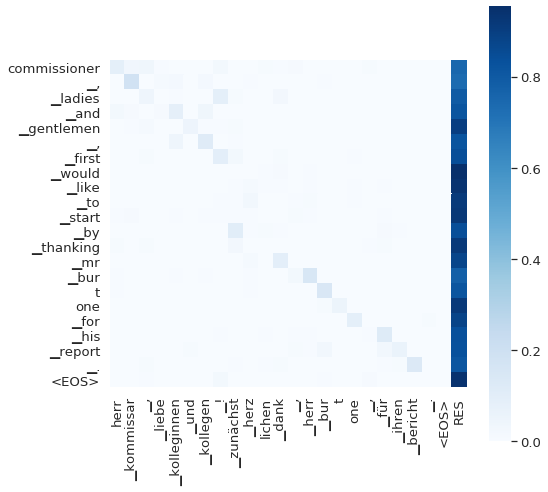

In [20]:
layer = 0

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(8,8))

df = pd.DataFrame(cross_attn_contributions[layer],columns=src_tok + ['<EOS>'] + ['RES'],index=pred_tok + ['<EOS>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)
print('mean residual',df['RES'].mean(), 'std', df['RES'].std())

### Self-attention decoder per layer

torch.Size([6, 22, 22])


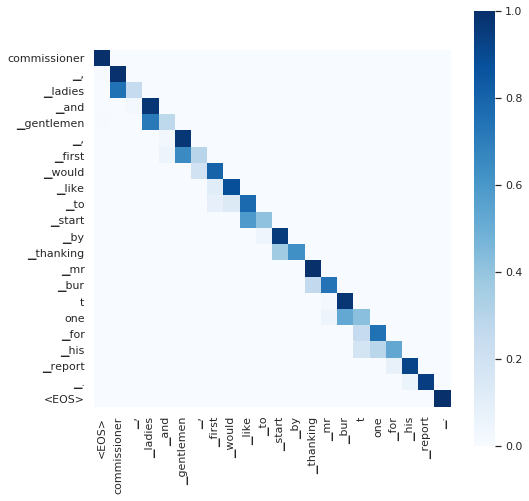

In [21]:
layer = 0
self_attn_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
print(self_attn_dec_contributions.size())
plt.figure(figsize=(8,8))
self_attn_dec_contributions = self_attn_dec_contributions.detach().cpu().numpy()
df = pd.DataFrame(self_attn_dec_contributions[layer],columns= ['<EOS>'] + pred_tok, index=pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True);

### Cross + self-attention per layer

We multiply the contributions of the decoder self-attention by the value of RES, and concatenate.

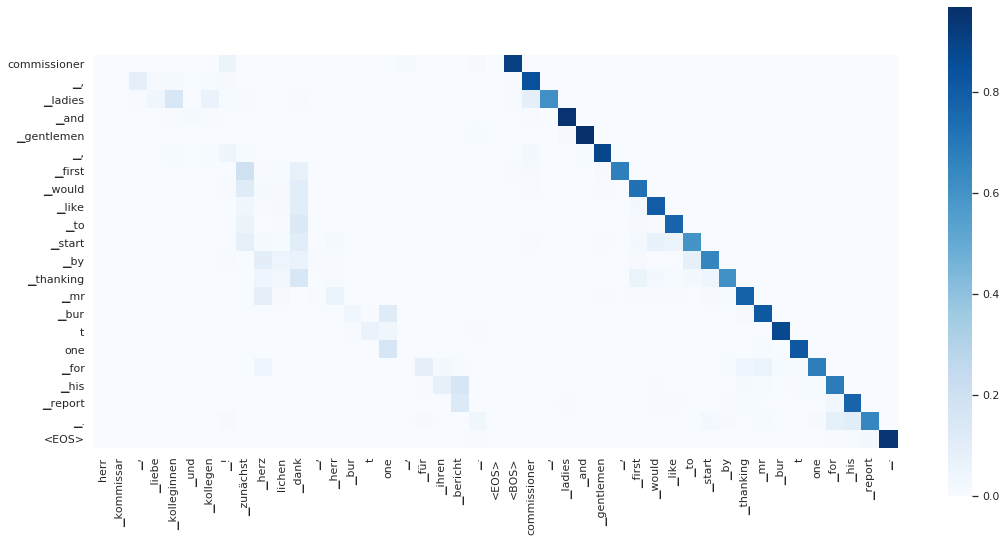

In [22]:
layer = 3
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(18,9))
df = pd.DataFrame(final_cross_contributions_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + pred_tok, index = pred_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True);

## Rollout analysis

### Rollout of the encoder

In [23]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']

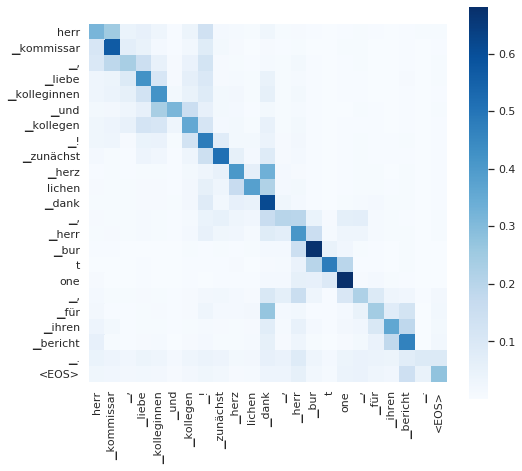

In [24]:
# Encoder self-attention relevances in last layer (full encoder rollout)
plt.figure(figsize=(8,8))
df = pd.DataFrame(relevances_enc_self_attn[-1].cpu().detach().numpy(),columns=src_tok + ['<EOS>'], index=src_tok + ['<EOS>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Rollout of the entire model

In [25]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

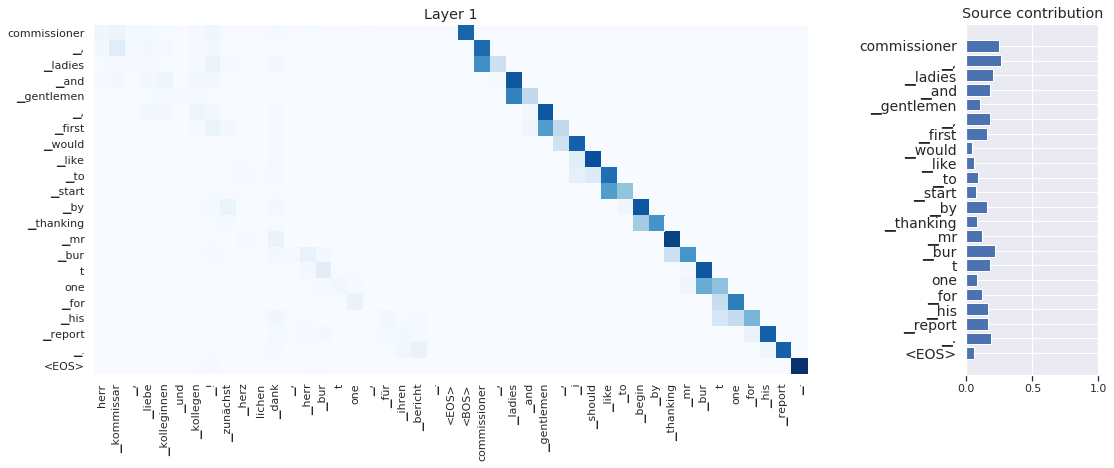

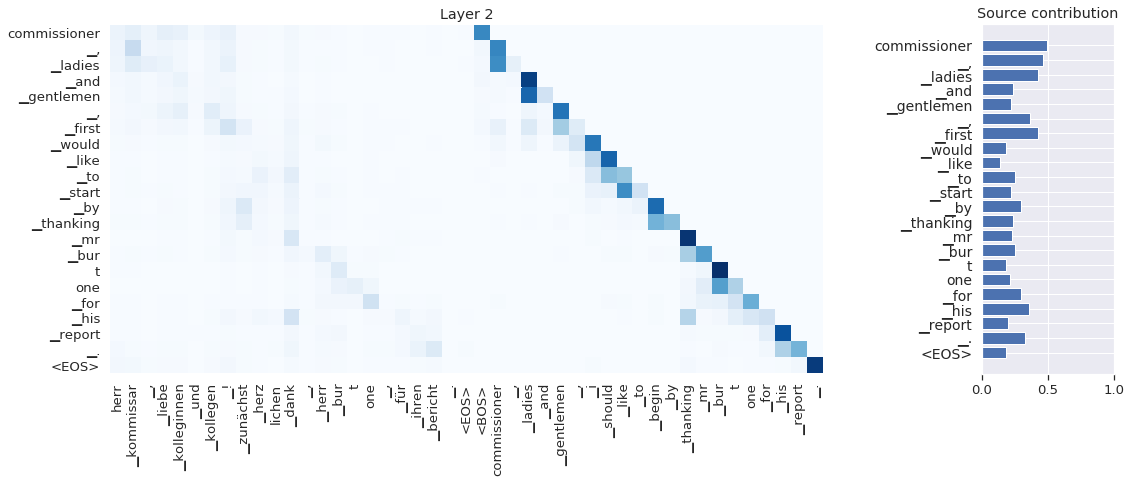

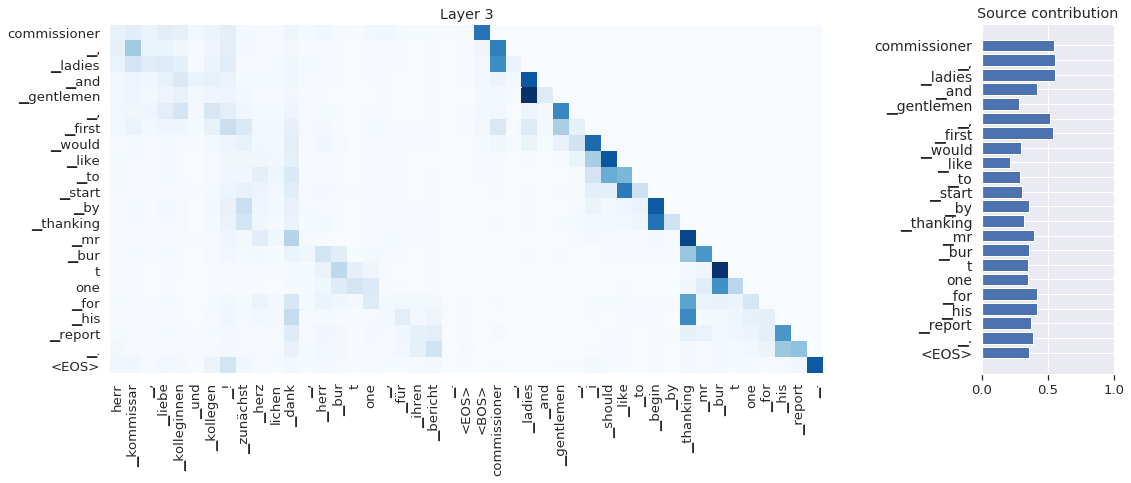

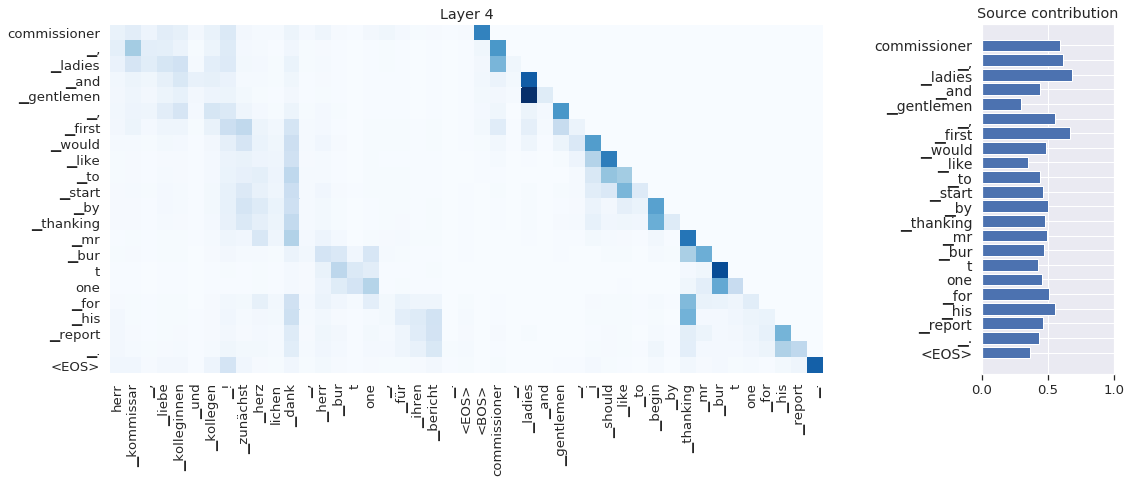

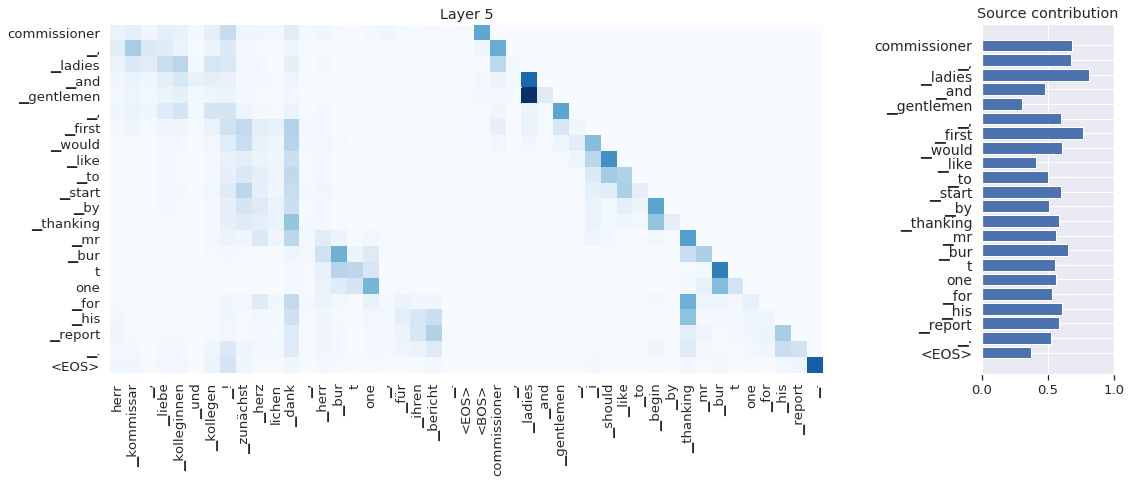

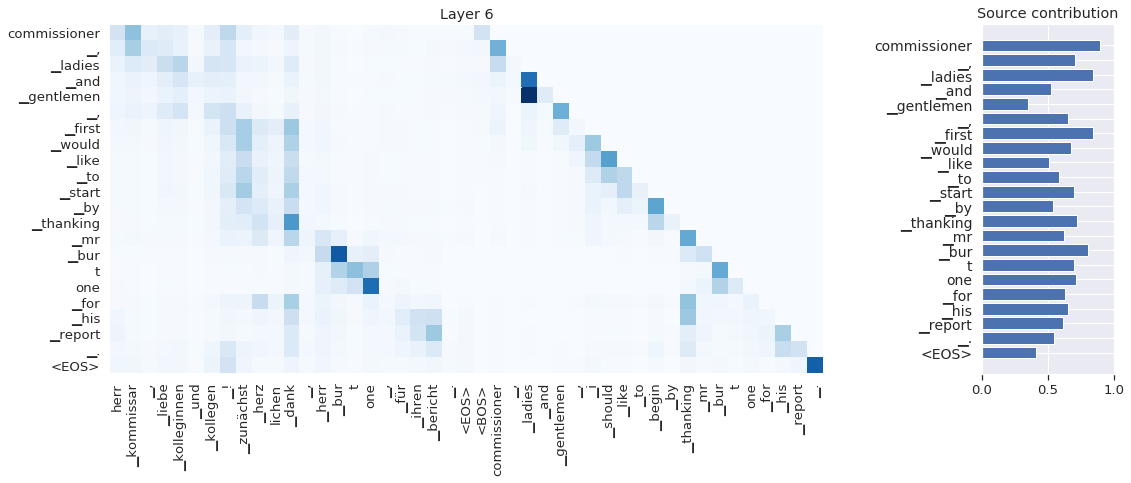

In [26]:
from matplotlib.gridspec import GridSpec

for layer in range(0,num_layers):

    fig = plt.figure(figsize=(18, 20))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + tgt_tok, index = pred_tok + ['<EOS>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:len(src_tok)].sum(-1)
    src_contribution
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = tgt_tok + ['<EOS>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(tgt_tok + ['<EOS>'])), df_src_contribution.src_contribution, align='center')
    plt.yticks(ticks = range(0,len(tgt_tok + ['<EOS>'])) ,labels = pred_tok + ['<EOS>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

In [27]:
# plt.figure(figsize=(20,8),dpi=200)
# df = pd.DataFrame(contributions_rollout_layer_np, columns = src_tok + ['<EOS>'] + ['<BOS>'] + tgt_tok, index = pred_tok + ['<EOS>'])
# sns.set(font_scale=1.6)
# sns.heatmap(df,cmap="Blues",square=True,cbar=True);

## Word-word alignments (source-target) from contributions

In [28]:
contribution_pred_src = contributions_rollout_layer_np[:,:len(src_tok)+1]
src_word_to_bpe = align.convert_bpe_word(src_tok_str, src_word_sent)
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str, tgt_word_sent)
contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

(20, 20)

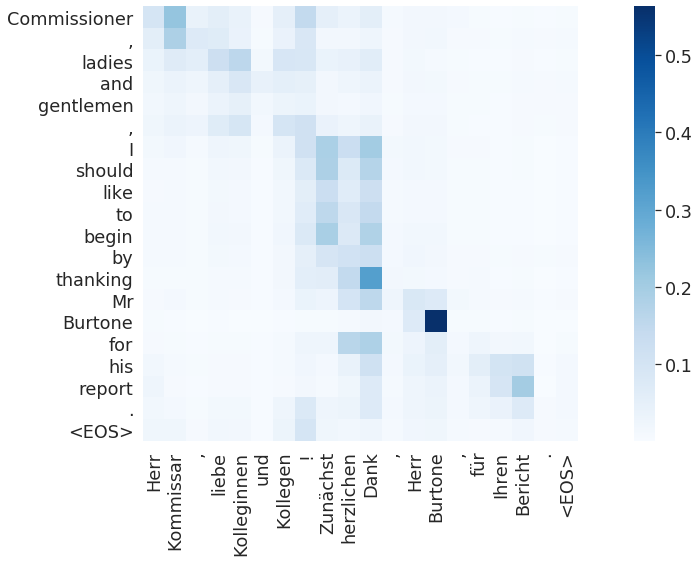

In [29]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['<EOS>'], index = tgt_word_sent.split() + ['<EOS>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

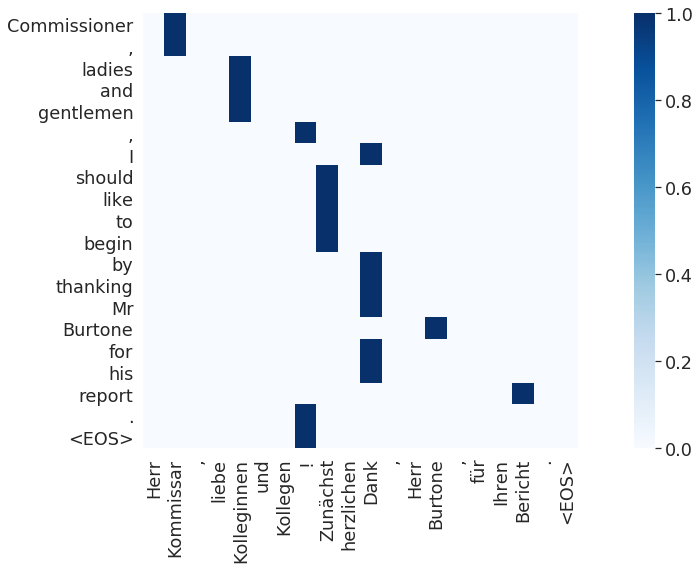

In [30]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['<EOS>'], index = tgt_word_sent.split() + ['<EOS>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

### Gold Alignment

Herr Kommissar , liebe Kolleginnen und Kollegen ! Zunächst herzlichen Dank , Herr Burtone , für Ihren Bericht .

Commissioner , ladies and gentlemen , I should like to begin by thanking Mr Burtone for his report .



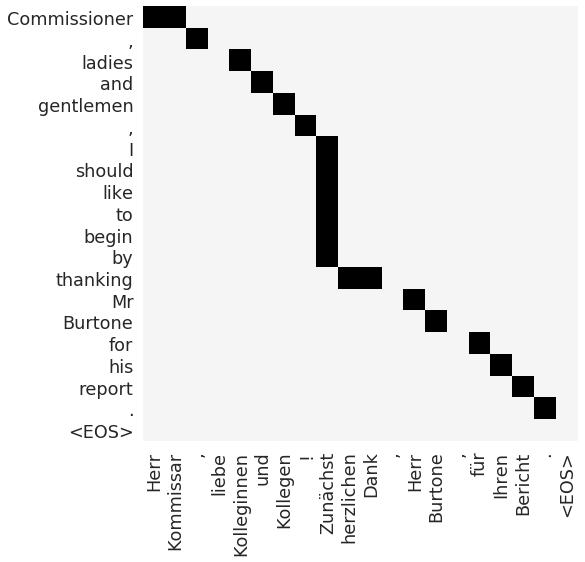

In [31]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["whitesmoke", "gainsboro", "lightgrey", "lightgray", "silver",
            "darkgrey", "darkgray", "grey", "gray", "dimgrey", "dimgray", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
i=3
src_word_sent = src_word_sents[i]
print(src_word_sent)
tgt_word_sent = tgt_word_sents[i]
print(tgt_word_sent)

attention_matrix = np.zeros((len(tgt_word_sent.split())+1,len(src_word_sent.split())+1))
with open(gold_alignment, 'r') as f:
    line = f.readlines()[i]
    for alignment_string in line.split():
        t, s = parse_single_alignment(alignment_string, reverse=True)
        attention_matrix[t-1][s-1] = 1
#attention_matrix = attention_matrix[[len(attention_matrix)-1]+list(range(0,len(attention_matrix)-1))]

plt.figure(figsize=(8,8))
fontsize = 10
rotation = 90
df_gold = pd.DataFrame(attention_matrix, columns=src_word_sent.split()+["<EOS>"],index=tgt_word_sent.split()+["<EOS>"])
sns.heatmap(df_gold,cmap=cmap,cbar=False,square=True)
sns.set(font_scale=1)
